# Classification from scratch

In [1]:
import os

# Set CML_ROOT to root data mount point
os.environ["CML_ROOT"] = "~/mnt/rhino"

In [2]:
%matplotlib inline

from copy import deepcopy
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter, MorletWaveletFilter

## Loading data

We start by loading the data index of all RAM subjects:

In [3]:
df = get_data_index("r1")

To train a classifier, we want to analyze record-only experiments. Here, we'll just consider FR1. Let's choose subject R1111M and see how many FR1 sessions they completed:

In [4]:
df[(df.subject == "R1111M") & (df.experiment == "FR1")][["subject", "experiment", "session"]]

,subject,experiment,session
616,R1111M,FR1,0
617,R1111M,FR1,1
618,R1111M,FR1,2
619,R1111M,FR1,3


Four sessions gives us a fair amount of data to work with, so let's start by creating a reader so that we can load montage ("pairs") information, events, and EEG data.

In [5]:
reader = CMLReader("R1111M", "FR1")
pairs = reader.load("pairs")

In general, we can always use `reader.load` to load any kind of data, but since we want to get FR1 events from all sessions completed by R1111M, we instead use the `reader.load_events` convenience method. Under the hood, this class method iterates through a given list of subjects, experiments, and sessions and returns a single `DataFrame` combining all relevant events. Let's hold out the last session, though, so that we can test on it later.

In [6]:
events = reader.load_events(["R1111M"], ["FR1"])

Now we need to load EEG segments for all word events. To select word onsets, we utilize the `events` accessor, but we could just as easily use standard `pandas` querying.

In [7]:
%%time
eeg = reader.load_eeg(events=events.events.words,
                      rel_start=0,
                      rel_stop=1600,
                      scheme=pairs)

CPU times: user 1.71 s, sys: 1.3 s, total: 3.01 s
Wall time: 12.9 s


Let's inspect a few signals at random:

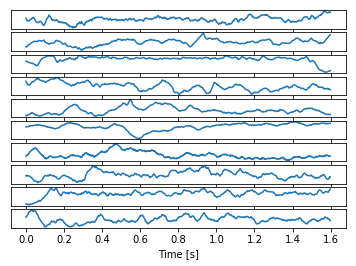

In [8]:
n_signals = 10
fig, axes = plt.subplots(n_signals, sharex=True)
chans = np.random.choice(eeg.data.shape[1], n_signals).astype(int)

for i, ax in zip(chans, axes):
    data = eeg.data[0, i]
    t = np.arange(len(data)) / eeg.samplerate
    ax.plot(t, data)
    ax.set_yticks([])
    ax.set_xlabel("Time [s]")

## Compute features for the classifier

In order to train a classifier, we need to convert our time series EEG data into power features. To do so, we'll use [PTSA](https://github.com/pennmem/ptsa_new) for its filtering capabilities. For Morlet wavelet decomposition, we'll also add a 1 second mirror buffer.

In [9]:
ts = eeg.to_ptsa().add_mirror_buffer(1)

For comparison, let's look at our signals now with this added buffer.

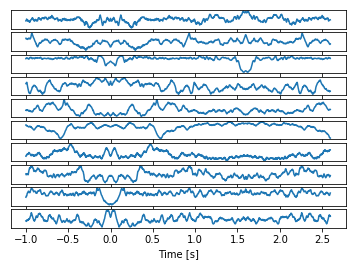

In [10]:
fig, axes = plt.subplots(n_signals, sharex=True)

for i, ax in zip(chans, axes):
    data = ts.data[0, i]
    ax.plot(ts.time, data)
    ax.set_yticks([])
    ax.set_xlabel("Time [s]")

Next we remove line noise using a [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter).

In [11]:
%%time
bf = ButterworthFilter(ts, [58., 62.], order=4, filt_type="stop")
ts2 = bf.filter()

CPU times: user 8.34 s, sys: 3.09 s, total: 11.4 s
Wall time: 11.4 s


Let's again inspect our signals after this filtering:

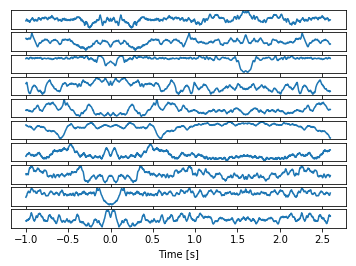

In [12]:
fig, axes = plt.subplots(n_signals, sharex=True)

for i, ax in zip(chans, axes):
    data = ts2.data[0, i]
    ax.plot(ts2.time, data)
    ax.set_yticks([])
    ax.set_xlabel("Time [s]")

With the initial data cleaning out of the way, we can begin computing spectral powers. Now we compute powers for 8 log-spaced frequencies from 6 to 180 Hz and finally remove the mirror buffer we added.

In [13]:
%%time
freqs = np.logspace(np.log10(6), np.log10(180), 8)
mwf = MorletWaveletFilter(ts2, freqs=freqs, output="power", cpus=2)
powers = mwf.filter().remove_buffer(1)

CPP total time wavelet loop:  30.692717790603638
CPU times: user 43.9 s, sys: 9.51 s, total: 53.4 s
Wall time: 36.2 s


Compute the mean powers over time for each event and zscore:

In [14]:
%%time
axis = [i for i, dim in enumerate(powers.dims) if dim == "time"][0]
mean_powers = np.log10(powers.data.mean(axis=axis))
zscored = zscore(mean_powers, axis=1, ddof=1)

CPU times: user 3.24 s, sys: 9.14 s, total: 12.4 s
Wall time: 20.3 s


Let's take a look at spectrograms for a recalled word compared to a word that was not recalled.

Text(0.5,0,'Channel number')

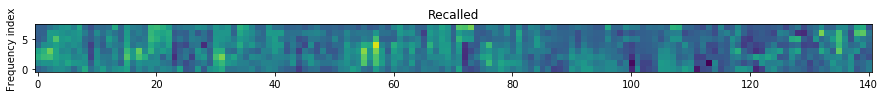

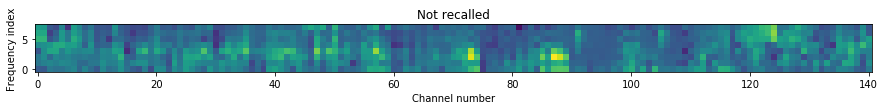

In [15]:
def plot_spectrogram(ax, data):
    cax = ax.imshow(data, interpolation="none", origin="lower")
    ax.set_ylabel("Frequency index")
    return cax

recalled = np.random.choice(events.events.words_recalled.index)
not_recalled = np.random.choice(events.events.words_not_recalled.index)

figsize = (15, 15)
fig1, ax1 = plt.subplots(figsize=figsize)
cax1 = plot_spectrogram(ax1, zscored[:, recalled, :])

fig2, ax2 = plt.subplots(figsize=figsize)
cax2 = plot_spectrogram(ax2, zscored[:, not_recalled, :])

# make the color scales the same
clims = cax1.get_clim() + cax2.get_clim()
cmin, cmax = min(clims), max(clims)
cax1.set_clim(cmin, cmax)
cax2.set_clim(cmin, cmax)

ax1.set_title("Recalled")
ax2.set_title("Not recalled")
ax2.set_xlabel("Channel number")

## Train the classifier

We're using L2 logistic regression which requires a 2-D features matrix to train:

In [16]:
def zscores_to_features(zscores, events):
    """Converts a 3-D z-scored powers array into a 2D feature matrix."""
    return zscores.swapaxes(0, 1).reshape((len(events), -1))

In [17]:
def train_classifier(features, recalls):
    # words = events.events.words
    model = LogisticRegression(C=7.2e-4)
    model.fit(features, recalls)
    return model

In [18]:
words = events[events.type == "WORD"]
features = zscores_to_features(zscored, words)
classifier = train_classifier(features, words.recalled)

In [19]:
classifier

LogisticRegression(C=0.00072, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## Evaluating a classifier

Typically we perform leave-one-session-out (LOSO) cross validation (or LOLO cross validation for single record-only sessions) rather than using random sampling to choose training and test datasets. This is in part so that we can evaluate how well the classifier generalizes to multiple sessions. LOSO/LOLO validation is also more sensible than random sampling because within a list, items are not truly independent (items between lists may also not be truly independent, but it's a closer approximation to reality).

### LOSO cross validation

In [20]:
def loso_probs(classifier, features, events, recalls):
    """Compute classifier outputs while leaving each session out one at a time.
    
    Returns
    -------
    probs : np.ndarray
        Classifier output for each event.
    
    """
    classifier2 = deepcopy(classifier)
    probs = np.empty_like(recalls, dtype=np.float)
    
    for session in events.session.unique():
        # select training data (all but one session)
        train_mask = events.session != session
        train_features = features[train_mask]
        train_recalls = recalls[train_mask]
        
        # select testing data (the left out session)
        test_mask = events.session == session
        test_features = features[test_mask]
        
        # fit and evaluate
        classifier2.fit(train_features, train_recalls)
        probs[test_mask] = classifier2.predict_proba(test_features)[:, 1]
    
    return probs

In [21]:
def permuted_loso_xval(classifier, features, events, num_permutations=10):
    """Perform permuted leave-one-session-out cross validation.
    
    Parameters
    ----------
    classifier
        The trained sklearn model
    features : np.ndarray
        Features matrix
    events : pd.DataFrame
        Word encoding events
    num_permutations : int
        Number of permutations to run for cross validation
        
    """
    # placeholder for AUC scores
    aucs = np.empty(num_permutations, dtype=np.float)
    
    recalls = events.recalled
    permuted_recalls = recalls.copy()
    
    for perm in range(num_permutations):
        for session in events.session.unique():
            # select current session to leave out
            session_mask = events.session == session
            
            # shuffle recalls so we can get our null distribution
            permuted_recalls.loc[session_mask] = recalls[session_mask].sample(frac=1).values
            
        # compute null distribution probabilities
        probs = loso_probs(classifier, features, events, permuted_recalls)
        aucs[perm] = roc_auc_score(recalls, probs)
    
    return aucs

In [22]:
num_permutations = 1000

In [23]:
permuted_aucs = pd.Series(permuted_loso_xval(classifier, features, words, num_permutations))

In [24]:
probs = loso_probs(classifier, features, words, words.recalled)

In [25]:
fpr, tpr, _ = roc_curve(words.recalled, probs)
auc = roc_auc_score(words.recalled, probs)
pvalue = np.count_nonzero((permuted_aucs >= auc) / len(permuted_aucs))
pvalue_str = "p < 0.001" if not pvalue else "p = {:.3f}".format(str(pvalue))

AUC = 0.714 , p < 0.001


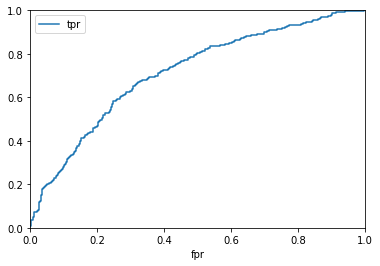

In [26]:
ax = pd.DataFrame({"fpr": fpr, "tpr": tpr}).plot(x="fpr", y="tpr")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
print("AUC = {:.3f}".format(auc), ",", pvalue_str)

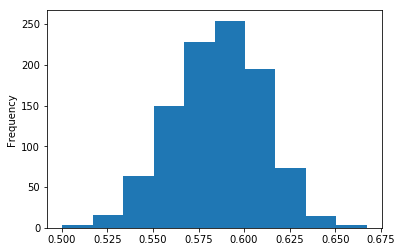

In [27]:
permuted_aucs.plot.hist()